# 多様体学習
- PCAは非線形な関係性を上手く表現できない。
  - 実質的に座標軸の移動、回転を行っているだけであるため
- 多様体学習であれば非線形データの次元削減が出来る
  - 2次元の分布データをスイスロールのように巻いた状態を考えると、これは3次元の分布となるが、このスイスロールを広げると、2次元のデータに戻る

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 多様体学習：HELLO
2次元にHELLOの文字の型にデータを分布させる。

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

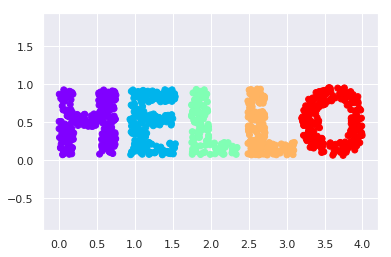

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

## 多次元尺度法(Multidimensional Scaling, MDS)
- 特定のx, yの値は重要ではない。HELLOという構造はデータを拡大、縮小、回転させても変わらない

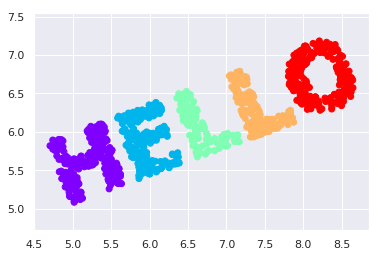

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

- データの持つ構造に関して、重要なのはxとyの値ではなく、点と点とのあいだの距離である。
  - これを表現するための一般的な方法は距離行列Dを使用することである
  - N点に対して、点iと点jの間の距離を示す(i, j)の用を持つNxN行列
- Scikit-Learnでは`pairwise_distances`関数でデータに対してこれを行うことが出来る

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

データを可視化する。

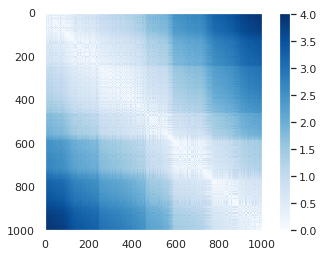

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

回転したデータから得られる行列は同じである。

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

- 距離行列は回転などを行っても不変であることは分かるが、上記のような可視化は直感的に理解できるものでない
  - HELLOというという構造は距離行列を眺めても理解できるものでない
- (x,y)座標から距離行列を計算することは簡単であったが、距離行列から(x,y)座標に変換するのは難しい
- 多様体学習は距離行列からD次元の座標のデータを復元する

dissimilarityを`precomputed`で指定して、距離行列を渡して、実行する。

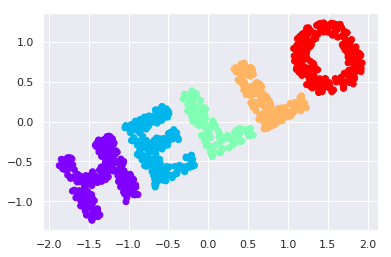

In [8]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

- MDSを使用して距離行列から2次元の座標を得ることが出来た

## 多様体学習としてのMDS
- これが便利なのは何次元であっても距離行列が計算できること
- 例えば、HELLOを2次元でなく3次元に射影する

In [9]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

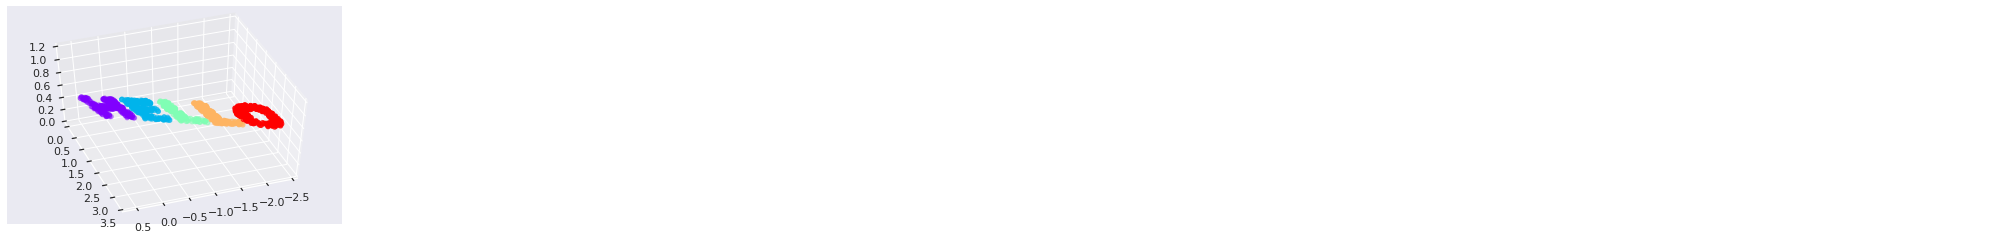

In [10]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

MDSでこの3次元で計算した距離行列を入力して、この距離行列に対して2次元で当てはめるとする。結果として、元のデータの表現を復元する。

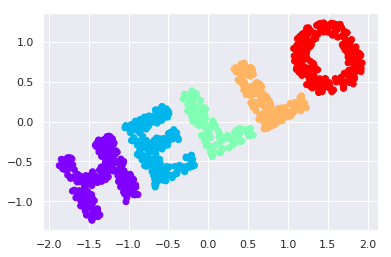

In [11]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

- 高次元のデータから、データ間の関係性を保持しながら、データのより低次元な表現が得られる
- MDSの場合は全ての点同士の距離が保存される

### MDS補足
MDSは得られた距離行列Dからサンプル行列Xを求める手法となる。

回転などが行われても距離行列Dは変わらないことから、サンプル行列Xは一意に求まるわけではなく、距離行列Dを満たすようなXの内の1つを求めることとなる。

参考

- http://www.is.ouj.ac.jp/lec/data/C07/C07.pdf

## 非線形の埋め込み：MDSが失敗する場合
- これまではデータを回転、平行移動、拡大縮小を高次元空間で行ったものを扱ってきたが、これらは線形的なものが埋め込まれたにすぎない
- MDSは非線形な埋め込みがあると失敗してしまう

HELLOの形を3次元上でS字にしたものをデータとして使う。

In [12]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

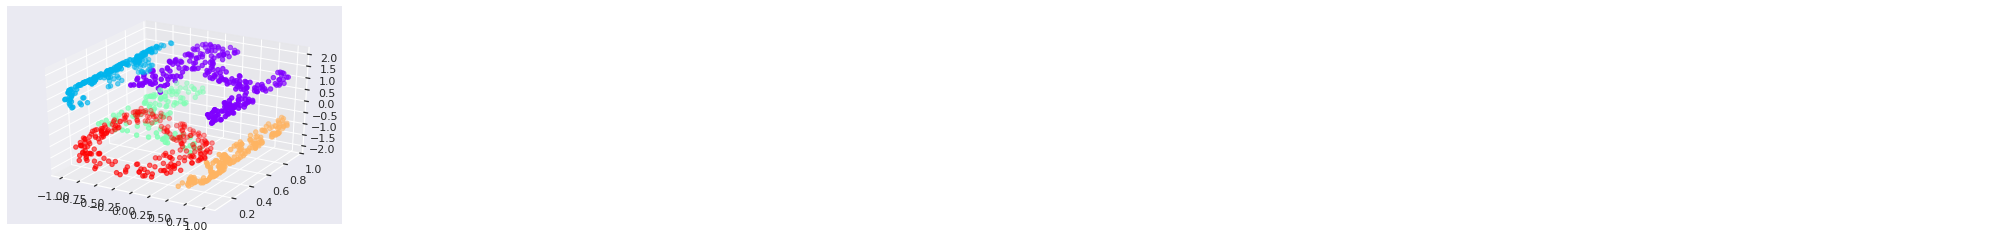

In [13]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

- シンプルなMDSでこのデータを扱うと、埋め込まれた多様体の関係性が失われてしまう

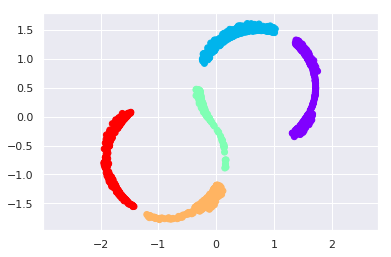

In [14]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

## 非線形多様体：Loccaly Linear Embedding
- MDSが非線形を上手く扱えないのは、遠く離れた点を含めた全ての点間の距離の関係性を保存するから
- 近くの点のみの距離のみを保存するようなアルゴリズムであれば求めるものに近づく

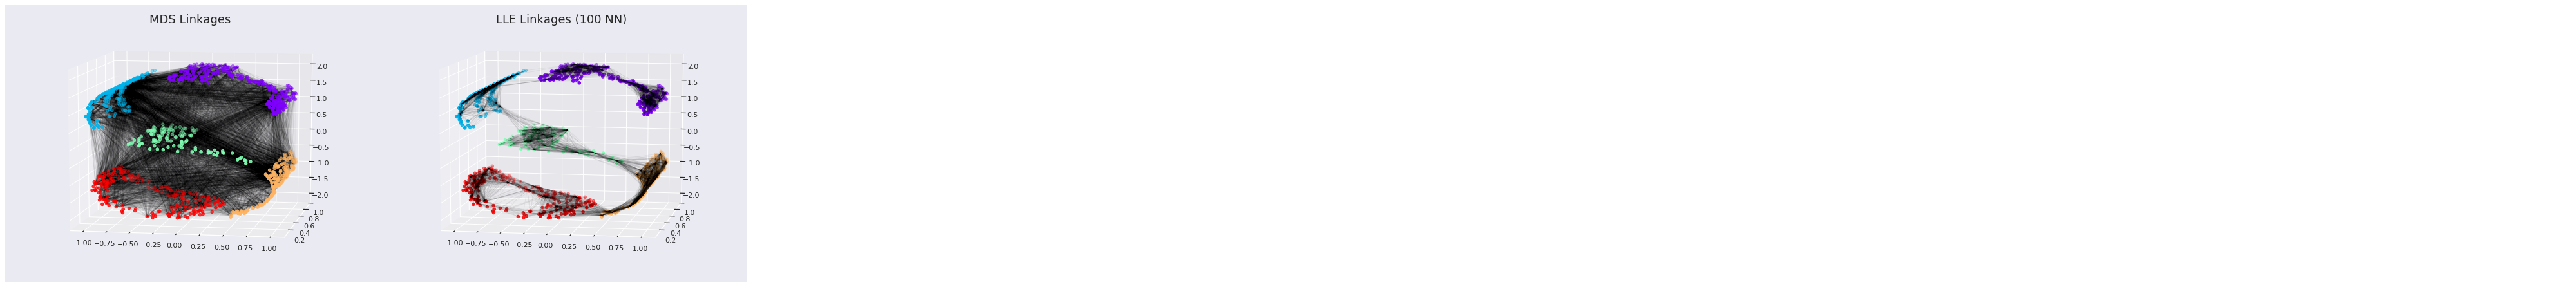

In [15]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn.neighbors import NearestNeighbors

# construct lines for MDS
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
lines_MDS = [(XS[i], XS[j]) for i in ind[:100] for j in ind[100:200]]

# construct lines for LLE
nbrs = NearestNeighbors(n_neighbors=100).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = [(XS[ind[i]], XS[j]) for i in range(100) for j in nbrs[i]]
titles = ['MDS Linkages', 'LLE Linkages (100 NN)']

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(projection='3d'))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)

for axi, title, lines in zip(ax, titles, [lines_MDS, lines_LLE]):
    axi.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);
    axi.add_collection(Line3DCollection(lines, lw=1, color='black',
                                        alpha=0.05))
    axi.view_init(elev=10, azim=-80)
    axi.set_title(title, size=18)

- 左のMDSでは全ての点間の距離を保存しようとする
- 右のLLEではこの場合、近傍の100点の距離のみを保存するようにしている

- LLEはいくつかの種類があるが、ここではmodified LLEを使ってデータの復元をおこなう

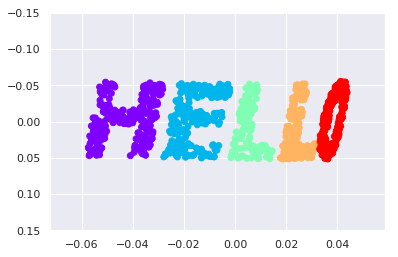

In [16]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

## 多様体学習のいくつかの考え
- 多様体学習は存在しないデータの取り扱いに対する良いフレームワークがない。PCAは繰り返しのアプローチがある
- 多様体学習はノイズデータの存在が短絡の原因となり、結果に大きな影響を与える
- 近傍の点として使用する数を適切なものにするのが難しい
- 次元を削減して得られた次元の意味が常に明らかではない。PCAでは明らか
- 計算量がO(N^2)かO(N^3)程度。PCAではランダム化して高速に行うことが可能

多様体学習のメリットは非線形な関係も扱えることにある。それ以外に関してはPCAの方が良さそうである。

Scikit-Learnではいくつかの種類の多様体学習がある。

- S字のようなちょっとした問題であれば、LLEやmodifie LLEが十分うまく動作する（`sklearn.manifold.LocallyLinearEmbedding`)
- 実際の世界の高次元のデータでは、LLEはひどい結果を出すことがしばしばある。isometric mapping(IsoMap)はより意味のある結果を導くであろう。（`sklearn.manifold.Isomap`）
- データが非常にクラスタ化されているならば、t-distributed stochastic neighbor embedding(t-SNE)が非常にうまく動作するが、他の方法と比較して非常に遅い（`sklearn.manifold.TSNE`）。

参考

- http://www.kurims.kyoto-u.ac.jp/~kyodo/kokyuroku/contents/pdf/2057-01.pdf
- http://neuro-educator.com/ml24/

## 例：顔のIsomap

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

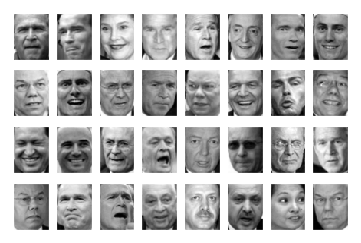

In [18]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

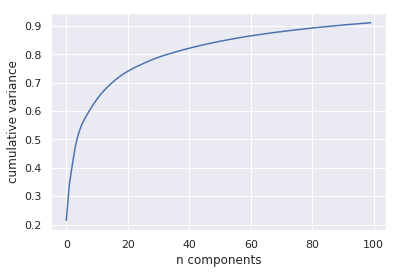

In [19]:
from sklearn.decomposition import PCA
model = PCA(100, svd_solver="randomized").fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

- PCAの結果から、90%の分散を保存するのに100成分程度必要なことが分かる
  - データはとても高次元であり、いくつかの成分だけで表現するのは難しいことが分かる
- 視覚的にデータを理解するのに、LLEやIsomapはとても役に立つ

In [20]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [21]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

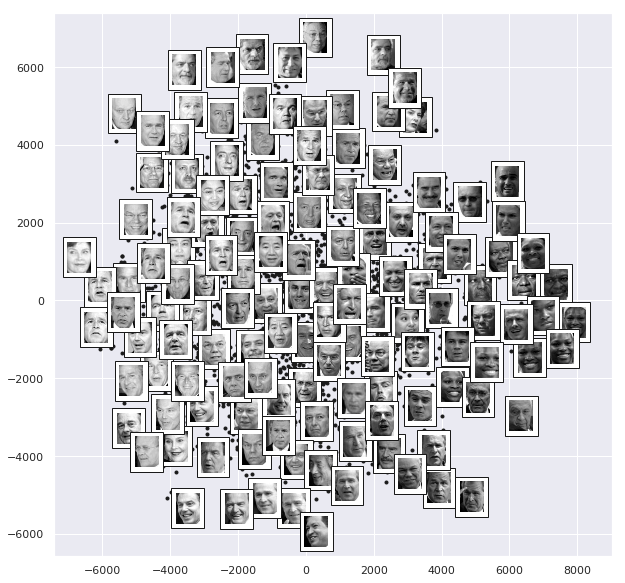

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

図を見ると2つのIsomapの次元は次のようなことを表していることが分かる

- 全体的な暗さや明るさを左から右の軸であらわしている
- 顔の向きを下から上の軸であらわしている